<a href="https://colab.research.google.com/github/nemoiitkgp/FWI-Codes-PhD/blob/main/BP_2004_GPU_T4_2%20(multiscale).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install deepwave scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 9.2 MB/s eta 0:00:00


### [3,5,7] = [50,50,50]

Using device: cuda
Grid: 1799x637 | dx=37.5m | Target: 7.0Hz

--- STAGE 1: 3.0 Hz ---
Epoch 5/50 | Scaled Loss: 0.133028
Epoch 10/50 | Scaled Loss: 0.102617
Epoch 15/50 | Scaled Loss: 0.085668
Epoch 20/50 | Scaled Loss: 0.075131
Epoch 25/50 | Scaled Loss: 0.068981
Epoch 30/50 | Scaled Loss: 0.060374
Epoch 35/50 | Scaled Loss: 0.057806
Epoch 40/50 | Scaled Loss: 0.054639
Epoch 45/50 | Scaled Loss: 0.050181
Epoch 50/50 | Scaled Loss: 0.050401

--- STAGE 2: 5.0 Hz ---
Epoch 5/50 | Scaled Loss: 0.131743
Epoch 10/50 | Scaled Loss: 0.109975
Epoch 15/50 | Scaled Loss: 0.113235
Epoch 20/50 | Scaled Loss: 0.097356
Epoch 25/50 | Scaled Loss: 0.097982
Epoch 30/50 | Scaled Loss: 0.090410
Epoch 35/50 | Scaled Loss: 0.089451
Epoch 40/50 | Scaled Loss: 0.088255
Epoch 45/50 | Scaled Loss: 0.092076
Epoch 50/50 | Scaled Loss: 0.095824

--- STAGE 3: 7.0 Hz ---


/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1429.000244140625, and a grid cell spacing of 37.5, there are only 5.44.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1450.0, and a grid cell spacing of 37.5, there are only 5.52.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1449.999755859375, and a grid cell spacing of 37.5, there are only 5.52.
  warnings.warn(


Epoch 5/50 | Scaled Loss: 0.152799
Epoch 10/50 | Scaled Loss: 0.151150
Epoch 15/50 | Scaled Loss: 0.146509
Epoch 20/50 | Scaled Loss: 0.148605
Epoch 25/50 | Scaled Loss: 0.140622
Epoch 30/50 | Scaled Loss: 0.131128
Epoch 35/50 | Scaled Loss: 0.136416
Epoch 40/50 | Scaled Loss: 0.131069
Epoch 45/50 | Scaled Loss: 0.141437
Epoch 50/50 | Scaled Loss: 0.136192


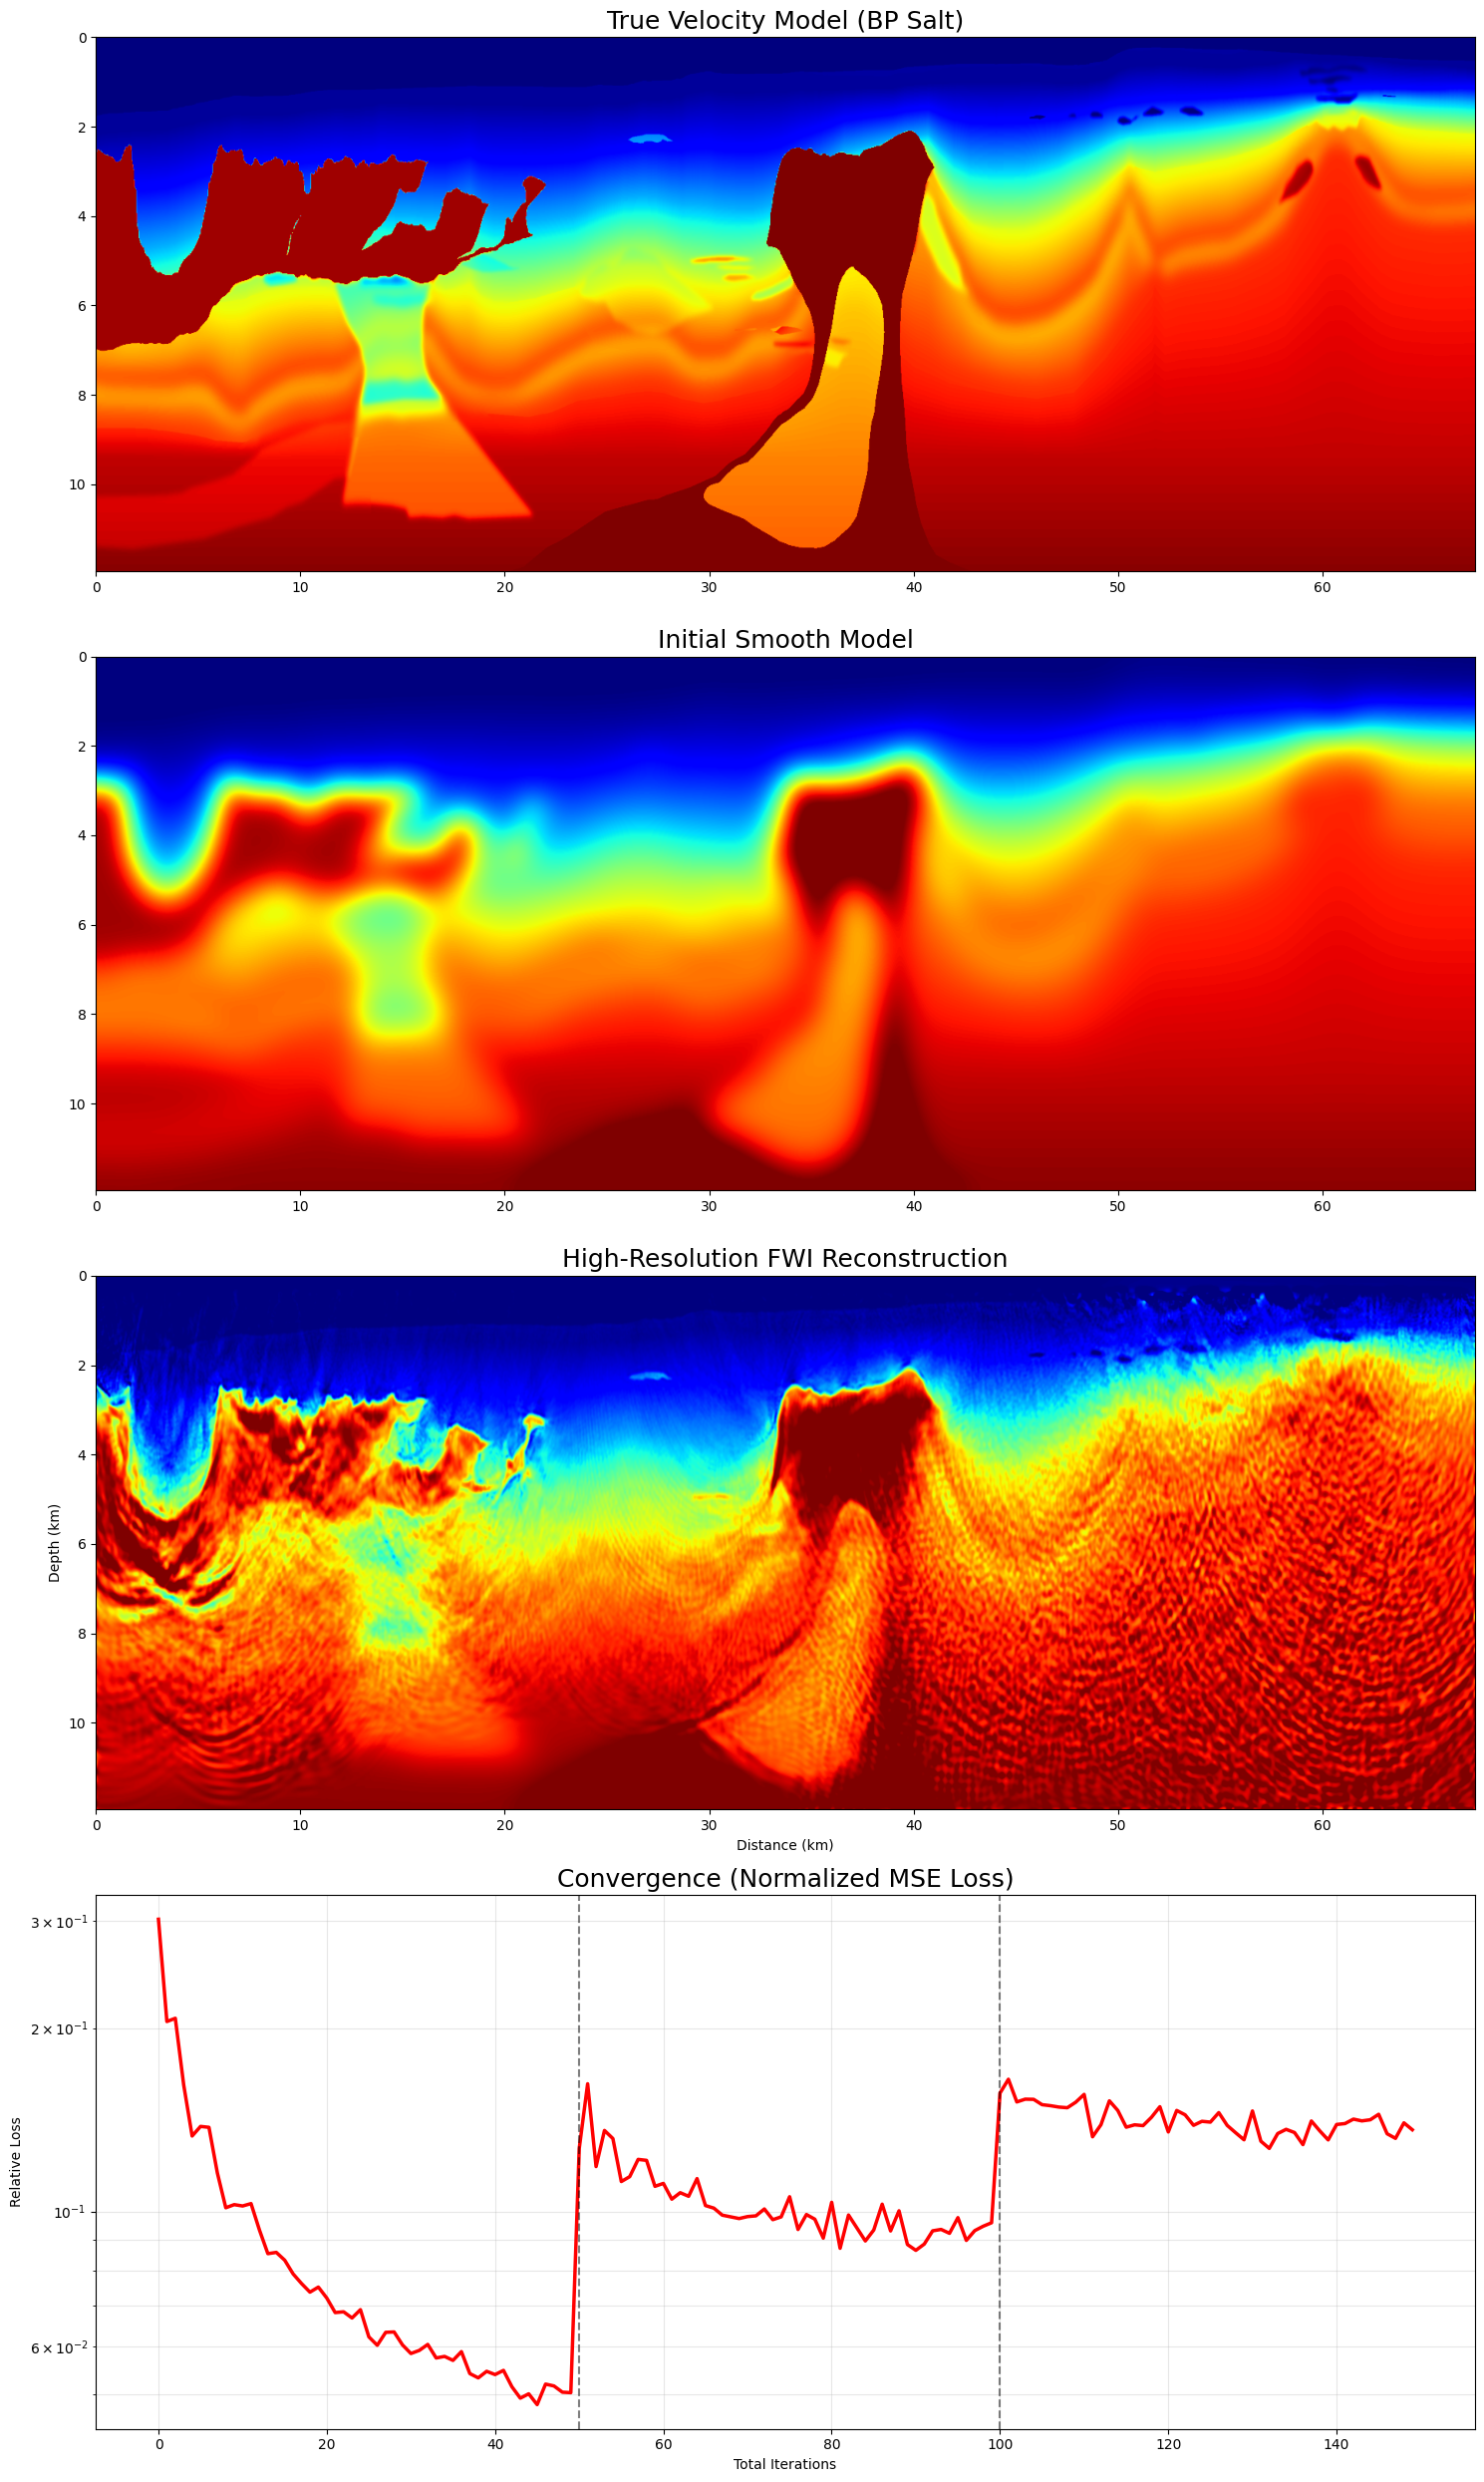

In [ ]:
import os
import gc
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
from scipy.ndimage import gaussian_filter

# --- CONFIGURATION & MEMORY ---
os.environ['PYTORCH_ALLOC_CONF'] = 'expandable_segments:True'

def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- ADVANCED GPU SMOOTHING (Edge Preserving) ---
def gpu_smooth(img, sigma):
    if sigma <= 0.1: return img
    kernel_size = int(2 * 4 * sigma + 1)
    if kernel_size % 2 == 0: kernel_size += 1
    x = torch.arange(kernel_size).to(device) - (kernel_size - 1) / 2
    kernel_1d = torch.exp(-x.pow(2) / (2 * sigma**2))
    kernel_1d /= kernel_1d.sum()
    kernel_2d = kernel_1d[:, None] * kernel_1d[None, :]
    kernel_2d = kernel_2d.expand(1, 1, -1, -1)
    img = F.pad(img.unsqueeze(0).unsqueeze(0), (kernel_size//2,)*4, mode='replicate')
    img = F.conv2d(img, kernel_2d)
    return img.squeeze()

# --- BP SALT MODEL LOADING ---
vp_path = 'BP_salt.bin'
nx0, nz0 = 5395, 1911
dx0, dz0 = 12.5, 6.25

if not os.path.exists(vp_path):
    print("Warning: BP_salt.bin not found. Using dummy for script verification.")
    vp_cpu = torch.ones(nx0, nz0) * 2000.0
else:
    vp_cpu = torch.from_file(vp_path, size=nx0 * nz0, dtype=torch.float32).reshape(nx0, nz0)

# Factor 3.0 (dx=37.5m) - This eliminates the 6Hz dispersion warning
factor = 3.0
vp_reduced = gaussian_filter(vp_cpu.numpy(), sigma=0.5)[::int(factor), ::int(factor)]
nx, nz = vp_reduced.shape
dx, dz = dx0 * factor, dz0 * factor
spacing = (dx, dz)

v_true = torch.from_numpy(vp_reduced).to(device)
v_init = torch.from_numpy(1.0 / gaussian_filter(1.0 / vp_reduced, sigma=20)).to(device)
v1 = v_init.clone().requires_grad_()

# --- ACQUISITION ---
n_shots = 24
batch_size = 3 # Adjusted for 15GB VRAM at dx=37.5
n_receivers_per_shot = 400
nt = 2000
dt = 0.004

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[:, 0, 0] = torch.linspace(20, nx - 21, n_shots).long()
source_loc[:, 0, 1] = 4

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 4
for i in range(n_shots):
    receiver_loc[i, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).long()

# --- PRE-CONDITIONING ---
water_depth_cells = int(450 / dz)
mask = torch.ones_like(v_init)
mask[:, :water_depth_cells] = 0.0
z_grad = torch.linspace(0, 1, nz).to(device)
depth_weight = (1.0 + 45.0 * z_grad**2.5).repeat(nx, 1) # Stronger weight for salt base

# --- MULTI-SCALE INVERSION ---
freqs = [3.0, 5.0, 7.0]
epochs_per_stage = 50
# Gradual learning rate reduction
lrs = [25.0, 15.0, 8.0]
history = []

print(f"Grid: {nx}x{nz} | dx={dx:.1f}m | Target: {freqs[-1]}Hz")

for f_idx, freq in enumerate(freqs):
    print(f"\n--- STAGE {f_idx+1}: {freq} Hz ---")
    cleanup()

    peak_time = 1.5 / freq
    source_amp = deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, 1, 1).to(device)

    # Observe data with wider PML to avoid boundary reflections (ripples)
    with torch.no_grad():
        obs_data_list = []
        for i in range(0, n_shots, batch_size):
            out = scalar(v_true, spacing, dt,
                         source_amplitudes=source_amp[i:min(i+batch_size, n_shots)],
                         source_locations=source_loc[i:min(i+batch_size, n_shots)],
                         receiver_locations=receiver_loc[i:min(i+batch_size, n_shots)],
                         pml_freq=freq, pml_width=[40, 40, 40, 40])
            obs_data_list.append(out[-1])
        obs_data = torch.cat(obs_data_list, dim=0)

    optimizer = torch.optim.Adam([v1], lr=lrs[f_idx])

    for epoch in range(epochs_per_stage):
        optimizer.zero_grad()
        epoch_loss = 0

        # Randomize shots to help skip local minima
        perm = torch.randperm(n_shots)

        for i in range(0, n_shots, batch_size):
            indices = perm[i:min(i+batch_size, n_shots)]

            out_pred = scalar(v1, spacing, dt,
                              source_amplitudes=source_amp[indices],
                              source_locations=source_loc[indices],
                              receiver_locations=receiver_loc[indices],
                              pml_freq=freq, pml_width=[40, 40, 40, 40],
                              model_gradient_sampling_interval=10) # VRAM Save

            # Normalizing loss by the scale of the observed data to prevent "jumps"
            loss = F.mse_loss(out_pred[-1], obs_data[indices]) / F.mse_loss(obs_data[indices], torch.zeros_like(obs_data[indices]))
            loss.backward()
            epoch_loss += loss.item()

        # Gradient Post-processing
        with torch.no_grad():
            # Apply Mask and Depth Gain
            v1.grad *= (mask * depth_weight)

            # Multi-scale smoothing: Sigma decreases as frequency increases
            # This allows the model to capture details while keeping salt solid
            sigma_val = 3.5 / (f_idx + 1)
            v1.grad.copy_(gpu_smooth(v1.grad, sigma=sigma_val))

        optimizer.step()

        # Hard constraints for BP model stability
        v1.data.clamp_(min=1450.0, max=4850.0)

        # Smooth the model itself slightly every epoch to prevent "checkerboard" artifacts
        if epoch % 2 == 0:
            v1.data.copy_(gpu_smooth(v1.data, sigma=0.2))

        avg_loss = epoch_loss / (n_shots // batch_size)
        history.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs_per_stage} | Scaled Loss: {avg_loss:.6f}")

# --- FINAL VISUALIZATION ---
fig, ax = plt.subplots(4, 1, figsize=(15, 25))
extent = [0, (nx*dx)/1000, (nz*dz)/1000, 0]
opts = {'cmap': 'jet', 'aspect': 'auto', 'extent': extent, 'vmin': 1500, 'vmax': 4600}

ax[0].imshow(v_true.cpu().T, **opts)
ax[0].set_title("True Velocity Model (BP Salt)", fontsize=18)

ax[1].imshow(v_init.cpu().T, **opts)
ax[1].set_title("Initial Smooth Model", fontsize=18)

im = ax[2].imshow(v1.detach().cpu().T, **opts)
ax[2].set_title("High-Resolution FWI Reconstruction", fontsize=18)
ax[2].set_xlabel("Distance (km)")
ax[2].set_ylabel("Depth (km)")

# Improved Loss Plot
ax[3].plot(history, color='red', lw=2.5)
ax[3].set_title("Convergence (Normalized MSE Loss)", fontsize=18)
ax[3].set_xlabel("Total Iterations")
ax[3].set_ylabel("Relative Loss")
ax[3].set_yscale('log')
ax[3].grid(True, which="both", ls="-", alpha=0.3)
# Mark stage transitions
for i in range(1, len(freqs)):
    ax[3].axvline(x=i*epochs_per_stage, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### [3,5,7] = [100,60,20]

Using device: cuda
Grid: 1799x637 | dx=37.5m | Target: 7.0Hz

--- STAGE 1: 3.0 Hz ---
Epoch 5/100 | Scaled Loss: 0.140829
Epoch 10/100 | Scaled Loss: 0.103997
Epoch 15/100 | Scaled Loss: 0.086968
Epoch 20/100 | Scaled Loss: 0.074958
Epoch 25/100 | Scaled Loss: 0.065922
Epoch 30/100 | Scaled Loss: 0.059962
Epoch 35/100 | Scaled Loss: 0.053996
Epoch 40/100 | Scaled Loss: 0.051108
Epoch 45/100 | Scaled Loss: 0.048577
Epoch 50/100 | Scaled Loss: 0.050558
Epoch 55/100 | Scaled Loss: 0.048273
Epoch 60/100 | Scaled Loss: 0.046149
Epoch 65/100 | Scaled Loss: 0.044204
Epoch 70/100 | Scaled Loss: 0.045145
Epoch 75/100 | Scaled Loss: 0.039418
Epoch 80/100 | Scaled Loss: 0.041532
Epoch 85/100 | Scaled Loss: 0.041045
Epoch 90/100 | Scaled Loss: 0.041026
Epoch 95/100 | Scaled Loss: 0.038598
Epoch 100/100 | Scaled Loss: 0.041141

--- STAGE 2: 5.0 Hz ---
Epoch 5/60 | Scaled Loss: 0.114164
Epoch 10/60 | Scaled Loss: 0.100703
Epoch 15/60 | Scaled Loss: 0.087721
Epoch 20/60 | Scaled Loss: 0.088548
Epoch 

/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1429.000244140625, and a grid cell spacing of 37.5, there are only 5.44.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1450.0, and a grid cell spacing of 37.5, there are only 5.52.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1449.999755859375, and a grid cell spacing of 37.5, there are only 5.52.
  warnings.warn(


Epoch 5/20 | Scaled Loss: 0.134759
Epoch 10/20 | Scaled Loss: 0.137291
Epoch 15/20 | Scaled Loss: 0.133997
Epoch 20/20 | Scaled Loss: 0.139264


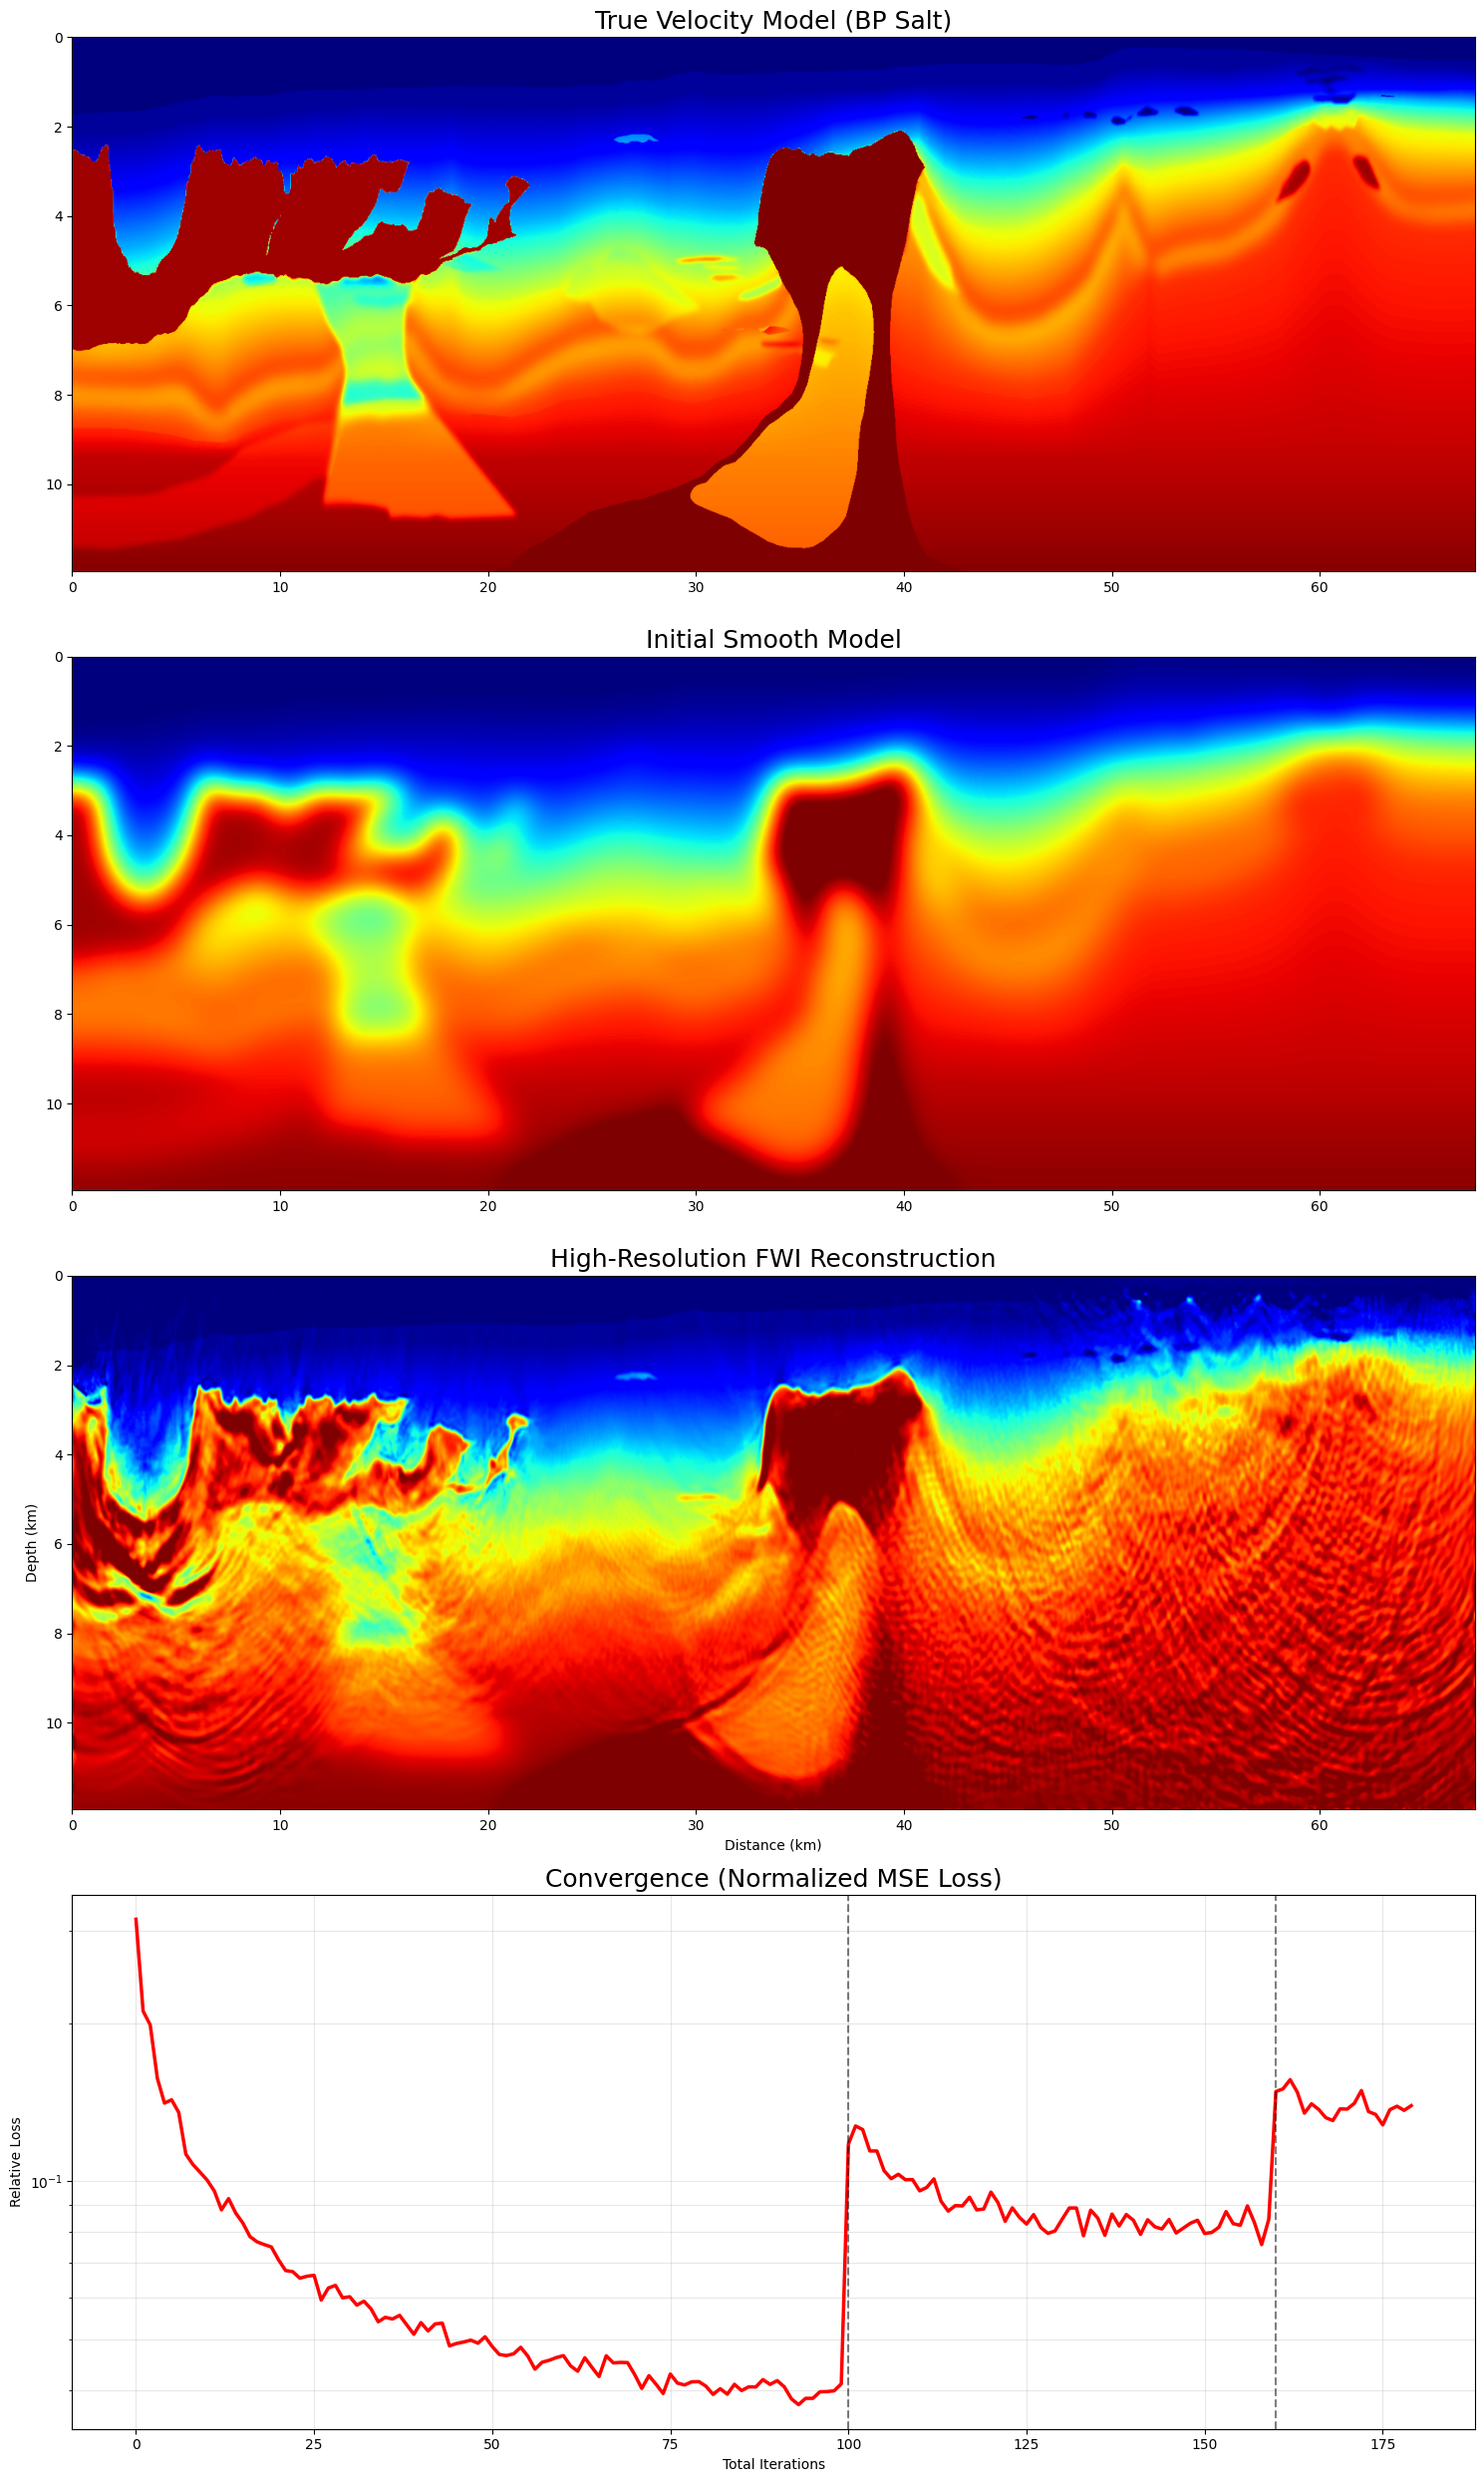

In [ ]:
import os
import gc
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
from scipy.ndimage import gaussian_filter

# --- CONFIGURATION & MEMORY ---
os.environ['PYTORCH_ALLOC_CONF'] = 'expandable_segments:True'

def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

#device = torch.device('cuda' if torch.available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- ADVANCED GPU SMOOTHING (Edge Preserving) ---
def gpu_smooth(img, sigma):
    if sigma <= 0.1: return img
    kernel_size = int(2 * 4 * sigma + 1)
    if kernel_size % 2 == 0: kernel_size += 1
    x = torch.arange(kernel_size).to(device) - (kernel_size - 1) / 2
    kernel_1d = torch.exp(-x.pow(2) / (2 * sigma**2))
    kernel_1d /= kernel_1d.sum()
    kernel_2d = kernel_1d[:, None] * kernel_1d[None, :]
    kernel_2d = kernel_2d.expand(1, 1, -1, -1)
    img = F.pad(img.unsqueeze(0).unsqueeze(0), (kernel_size//2,)*4, mode='replicate')
    img = F.conv2d(img, kernel_2d)
    return img.squeeze()

# --- BP SALT MODEL LOADING ---
vp_path = 'BP_salt.bin'
nx0, nz0 = 5395, 1911
dx0, dz0 = 12.5, 6.25

if not os.path.exists(vp_path):
    print("Warning: BP_salt.bin not found. Using dummy for script verification.")
    vp_cpu = torch.ones(nx0, nz0) * 2000.0
else:
    vp_cpu = torch.from_file(vp_path, size=nx0 * nz0, dtype=torch.float32).reshape(nx0, nz0)

# Factor 3.0 (dx=37.5m) - This eliminates the 6Hz dispersion warning
factor = 3.0
vp_reduced = gaussian_filter(vp_cpu.numpy(), sigma=0.5)[::int(factor), ::int(factor)]
nx, nz = vp_reduced.shape
dx, dz = dx0 * factor, dz0 * factor
spacing = (dx, dz)

v_true = torch.from_numpy(vp_reduced).to(device)
v_init = torch.from_numpy(1.0 / gaussian_filter(1.0 / vp_reduced, sigma=20)).to(device)
v1 = v_init.clone().requires_grad_()

# --- ACQUISITION ---
n_shots = 24
batch_size = 3 # Adjusted for 15GB VRAM at dx=37.5
n_receivers_per_shot = 400
nt = 2000
dt = 0.004

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[:, 0, 0] = torch.linspace(20, nx - 21, n_shots).long()
source_loc[:, 0, 1] = 4

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 4
for i in range(n_shots):
    receiver_loc[i, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).long()

# --- PRE-CONDITIONING ---
water_depth_cells = int(450 / dz)
mask = torch.ones_like(v_init)
mask[:, :water_depth_cells] = 0.0
z_grad = torch.linspace(0, 1, nz).to(device)
depth_weight = (1.0 + 45.0 * z_grad**2.5).repeat(nx, 1) # Stronger weight for salt base

# --- MULTI-SCALE INVERSION ---
freqs = [3.0, 5.0, 7.0]
epochs_per_stage = [100, 60, 20] # Updated iterations per frequency
# Gradual learning rate reduction
lrs = [25.0, 15.0, 8.0]
history = []

print(f"Grid: {nx}x{nz} | dx={dx:.1f}m | Target: {freqs[-1]}Hz")

for f_idx, freq in enumerate(freqs):
    print(f"\n--- STAGE {f_idx+1}: {freq} Hz ---")
    cleanup()

    peak_time = 1.5 / freq
    source_amp = deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, 1, 1).to(device)

    # Observe data with wider PML to avoid boundary reflections (ripples)
    with torch.no_grad():
        obs_data_list = []
        for i in range(0, n_shots, batch_size):
            out = scalar(v_true, spacing, dt,
                         source_amplitudes=source_amp[i:min(i+batch_size, n_shots)],
                         source_locations=source_loc[i:min(i+batch_size, n_shots)],
                         receiver_locations=receiver_loc[i:min(i+batch_size, n_shots)],
                         pml_freq=freq, pml_width=[40, 40, 40, 40])
            obs_data_list.append(out[-1])
        obs_data = torch.cat(obs_data_list, dim=0)

    optimizer = torch.optim.Adam([v1], lr=lrs[f_idx])

    for epoch in range(epochs_per_stage[f_idx]):
        optimizer.zero_grad()
        epoch_loss = 0

        # Randomize shots to help skip local minima
        perm = torch.randperm(n_shots)

        for i in range(0, n_shots, batch_size):
            indices = perm[i:min(i+batch_size, n_shots)]

            out_pred = scalar(v1, spacing, dt,
                              source_amplitudes=source_amp[indices],
                              source_locations=source_loc[indices],
                              receiver_locations=receiver_loc[indices],
                              pml_freq=freq, pml_width=[40, 40, 40, 40],
                              model_gradient_sampling_interval=10) # VRAM Save

            # Normalizing loss by the scale of the observed data to prevent "jumps"
            loss = F.mse_loss(out_pred[-1], obs_data[indices]) / F.mse_loss(obs_data[indices], torch.zeros_like(obs_data[indices]))
            loss.backward()
            epoch_loss += loss.item()

        # Gradient Post-processing
        with torch.no_grad():
            # Apply Mask and Depth Gain
            v1.grad *= (mask * depth_weight)

            # Multi-scale smoothing: Sigma decreases as frequency increases
            sigma_val = 3.5 / (f_idx + 1)
            v1.grad.copy_(gpu_smooth(v1.grad, sigma=sigma_val))

        optimizer.step()

        # Hard constraints for BP model stability
        v1.data.clamp_(min=1450.0, max=4850.0)

        # Smooth the model itself slightly every epoch to prevent "checkerboard" artifacts
        if epoch % 2 == 0:
            v1.data.copy_(gpu_smooth(v1.data, sigma=0.2))

        avg_loss = epoch_loss / (n_shots // batch_size)
        history.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs_per_stage[f_idx]} | Scaled Loss: {avg_loss:.6f}")

# --- FINAL VISUALIZATION ---
fig, ax = plt.subplots(4, 1, figsize=(15, 25))
extent = [0, (nx*dx)/1000, (nz*dz)/1000, 0]
opts = {'cmap': 'jet', 'aspect': 'auto', 'extent': extent, 'vmin': 1500, 'vmax': 4600}

ax[0].imshow(v_true.cpu().T, **opts)
ax[0].set_title("True Velocity Model (BP Salt)", fontsize=18)

ax[1].imshow(v_init.cpu().T, **opts)
ax[1].set_title("Initial Smooth Model", fontsize=18)

im = ax[2].imshow(v1.detach().cpu().T, **opts)
ax[2].set_title("High-Resolution FWI Reconstruction", fontsize=18)
ax[2].set_xlabel("Distance (km)")
ax[2].set_ylabel("Depth (km)")

# Improved Loss Plot
ax[3].plot(history, color='red', lw=2.5)
ax[3].set_title("Convergence (Normalized MSE Loss)", fontsize=18)
ax[3].set_xlabel("Total Iterations")
ax[3].set_ylabel("Relative Loss")
ax[3].set_yscale('log')
ax[3].grid(True, which="both", ls="-", alpha=0.3)
# Mark stage transitions
for i in range(1, len(freqs)):
    ax[3].axvline(x=sum(epochs_per_stage[:i]), color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()